In [17]:
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim
from sklearn.metrics import confusion_matrix
from elpv_reader import load_dataset
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# define functions

In [2]:
def calculate_metrics(conf_matrix):
    # True positives
    TP = np.diag(conf_matrix)
    # False positives
    FP = np.sum(conf_matrix, axis=0) - TP
    # False negatives
    FN = np.sum(conf_matrix, axis=1) - TP

    # Avoid division by zero
    precision = np.divide(TP, (TP + FP), out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
    recall = np.divide(TP, (TP + FN), out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)

    # Macro-average precision
    macro_precision = np.mean(precision)
    # Macro-average recall
    macro_recall = np.mean(recall)

    # Calculate macro-average F1 score, only for non-zero precision and recall
    f1_scores = np.divide(2 * precision * recall, (precision + recall), out=np.zeros_like(precision, dtype=float),
                          where=(precision + recall) != 0)
    macro_f1_score = np.mean(f1_scores)

    # Accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accuracy, macro_precision, macro_recall, macro_f1_score


In [3]:
def test_model(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in test_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [4]:
def smote_3d(minority, y_minority, percentage, clf, n_neighbors=5):
    # Flatten minority class samples to 2D arrays
    num_samples, dim1, dim2 = minority.shape
    minority_flat = minority.reshape(num_samples, dim1 * dim2)

    synthetic_flat = []
    counter = 0

    # Choose the appropriate number of samples to generate synthetic samples based on the provided percentage
    if percentage < 100:
        n_minority = int(len(minority_flat) * percentage / 100)
        minority_flat = minority_flat[np.random.choice(len(minority_flat), n_minority, replace=False), :]
        percentage = 100

    # Calculate the multiplier for the number of synthetic samples needed
    percentage = int(percentage / 100)

    # Use KNN to find neighbors
    knn = clf(n_neighbors=n_neighbors + 1)
    knn.fit(minority_flat, y_minority)

    for data_point in minority_flat:
        # Find the neighbors for each minority class sample point
        _, nnarray = knn.kneighbors(data_point.reshape(1, -1))
        nnarray = nnarray[0][1:]  # Exclude the sample itself

        # Generate synthetic samples for each minority class sample
        for _ in range(percentage):
            selected = np.random.choice(nnarray, 1)
            diff = minority_flat[selected[0]] - data_point
            gap = np.random.rand()
            synthetic_data_point = data_point + gap * diff
            synthetic_flat.append(synthetic_data_point)
            counter += 1

    # Reshape the synthetic sample data back to the original 3D shape
    synthetic = np.array(synthetic_flat).reshape(-1, dim1, dim2)

    print(f'Generated {counter} synthetic samples.')
    return synthetic

In [25]:
def plot_confusion_matrix(conf_matrix, class_names, name):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap='coolwarm', annot_kws={"color": "white"})
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(name)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.show()

# Load the dataset

In [5]:
images, proba, types = load_dataset()

# Data preprocessing, convert labels to integer indices

In [6]:
label_mapping = {0.0: 0, 0.3333333333333333: 1, 0.6666666666666666: 2, 1.0: 3}
proba = [label_mapping[label] for label in proba]
proba = np.array(proba)
types_mapping = {'mono': 1, 'poly': 0}
types = [types_mapping[t] for t in types]
types = np.array(types)

# Enhance the dataset

In [7]:
for n in range(2):
    for m in [1, 2]:
        minority_indices = np.where((proba == m) & (types == n))[0]
        minority_images = images[minority_indices]
        y_minority = proba[minority_indices]
        synthetic_images = smote_3d(minority_images, y_minority, m * 200, KNeighborsClassifier, n_neighbors=5)
        images = np.concatenate((images, synthetic_images), axis=0)
        proba = np.concatenate((proba, np.array([m] * len(synthetic_images))), axis=0)
        types = np.concatenate((types, np.array([n] * len(synthetic_images))), axis=0)

Generated 356 synthetic samples.
Generated 200 synthetic samples.
Generated 234 synthetic samples.
Generated 224 synthetic samples.


# Split the data into training and testing sets after the CustomDataset class

In [8]:
images_train, images_test, proba_train, proba_test, types_train, types_test = train_test_split(
    images,
    proba,
    types,
    test_size=0.25,  # Test set is 25%
    random_state=42  # Ensure the split is the same each time
)

# Define the dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, types, transform=None):
        self.images = images
        self.labels = labels
        self.types = types
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        type_ = self.types[idx]
        image = Image.fromarray(image).convert('L')
        image = image.convert('RGB')  # Convert grayscale images to three-channel RGB images
        if self.transform:
            image = self.transform(image)
        return image, label, type_


transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale images to three channels
    transforms.Resize((224, 224)),  # Resize images according to ShuffleNet requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Training dataset
train_dataset = CustomDataset(images_train, proba_train, types_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Testing dataset
test_dataset = CustomDataset(images_test, proba_test, types_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model

In [12]:
model = models.vgg11_bn(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.load_state_dict(torch.load('vgg11_bn.pth'))

if torch.cuda.is_available():
    model = model.cuda()

# Train the model

In [11]:
num_epochs = 0
accuracy = 0
while num_epochs <= 20:
    model.train()
    running_loss = 0.0
    # Progress bar
    loop = tqdm(train_dataloader, leave=True)
    for images, labels, _ in loop:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar
        loop.set_postfix(loss=running_loss / len(train_dataloader))

    # 在每个训练轮次后进行测试并打印正确率
    accuracy = test_model(model, test_dataloader)
    print(f"Accuracy of the network on the test images after epoch {num_epochs + 1}: {accuracy:.2f}")
    num_epochs += 1

# Predict and generate confusion matrices

Confusion Matrix - All Types:
[[332  11   5  18]
 [ 27 189   3   4]
 [ 11   0 116   0]
 [ 26   7   8 153]]
Accuracy: 0.8681318681318682
Precision: 0.8761252274295752
Recall: 0.8641707695024236
F1 Score: 0.8688705079982921


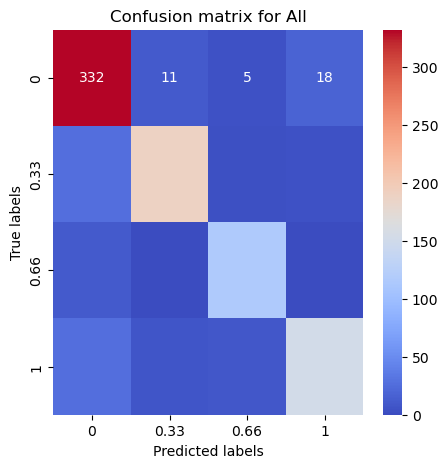

Confusion Matrix - Mono:
[[123   8   1   7]
 [  7  74   0   0]
 [  6   0  62   0]
 [  9   2   6  68]]
Accuracy: 0.8766756032171582
Precision: 0.8836114085814236
Recall: 0.877559259781717
F1 Score: 0.8795690922798459


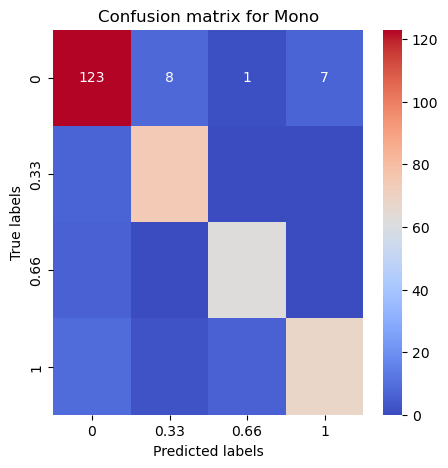

Confusion Matrix - Poly:
[[209   3   4  11]
 [ 20 115   3   4]
 [  5   0  54   0]
 [ 17   5   2  85]]
Accuracy: 0.8621973929236499
Precision: 0.8686928823613791
Recall: 0.8564086879485397
F1 Score: 0.8602611366438833


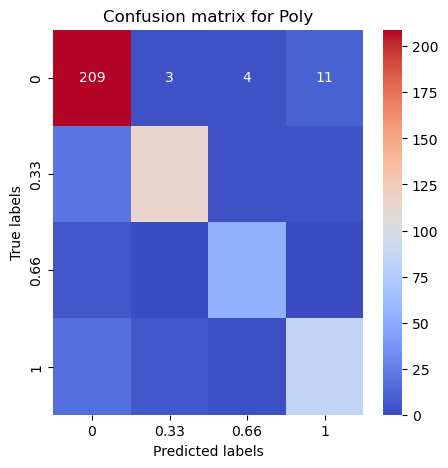

In [26]:
model.eval()
predictions = []
labels_list = []
types_list = []
with torch.no_grad():
    for images, labels, types in test_dataloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        types_list.extend(types)

class_names = ['0', '0.33', '0.66', '1']

# Confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)
accuracy, precision, recall, f1 = calculate_metrics(conf_matrix)
print('Confusion Matrix - All Types:')
print(conf_matrix)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix, class_names, 'Confusion matrix for All')

# Confusion matrix for Mono
mono_indices = [i for i, x in enumerate(types_list) if x == 1]
mono_predictions = [predictions[i] for i in mono_indices]
mono_labels = [labels_list[i] for i in mono_indices]
conf_matrix_mono = confusion_matrix(mono_labels, mono_predictions)
accuracy, precision, recall, f1 = calculate_metrics(conf_matrix_mono)
print('Confusion Matrix - Mono:')
print(conf_matrix_mono)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix_mono, class_names, 'Confusion matrix for Mono')

# Confusion matrix for Poly
poly_indices = [i for i, x in enumerate(types_list) if x == 0]
poly_predictions = [predictions[i] for i in poly_indices]
poly_labels = [labels_list[i] for i in poly_indices]
conf_matrix_poly = confusion_matrix(poly_labels, poly_predictions)
accuracy, precision, recall, f1 = calculate_metrics(conf_matrix_poly)
print('Confusion Matrix - Poly:')
print(conf_matrix_poly)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
plot_confusion_matrix(conf_matrix_poly, class_names, 'Confusion matrix for Poly')